In [1]:
import json
import math
import random
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from dataset import build_dataset
from integerembeddings.integer_embedding import IntegerSequenceEmbeddingPreprocessor
from mets.function_definitions import get_function_names
from model import create_token_guesser_model
from vocab import Vocab

# Training

In [2]:
# Define vocabulary and mapping
vocabulary = Vocab(get_function_names())
preprocessor = IntegerSequenceEmbeddingPreprocessor(load_model=False)

In [3]:
# Build model
model = create_token_guesser_model(vocabulary_size=vocabulary.size,
                                   sequence_encoding_layers=2,
                                   sequence_encoding_dim=128)

model.summary()

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, None, None,   0           ['encoder_inputs[0][0]']         
                                1)                                                                
                                                                                                  
 time_distributed (TimeDistribu  (None, None, None,   0          ['tf.expand_dims[0][0]']         
 ted)                           1)                                                            

In [4]:
# Training Parameters
max_curriculums = 5
training_dataset_size = 1000
advancement_attempts = 20
epochs = 10

In [5]:
# Setup
curriculums = [i / (max_curriculums - 1) for i in range(max_curriculums)]
recorded_training_data = {curriculum: [] for curriculum in curriculums}
iteration = 0

In [6]:
print(f"Complexities: ", curriculums)

Complexities:  [0.0, 0.25, 0.5, 0.75, 1.0]


In [7]:
def display_prediction_comparison(y_true, y_pred, vocabulary):
    for row_true, row_pred in zip(y_true, y_pred):
        y_true_tokens = {}
        y_pred_tokens = {}
        for token_id, (count_true, count_pred) in enumerate(zip(row_true, row_pred)):
            count_true = int(count_true)
            count_pred = float(count_pred)
            y_true_tokens[token_id] = count_true
            y_pred_tokens[token_id] = count_pred

        column_names = [vocabulary[token_id] for token_id in y_true_tokens.keys()]
        df = pd.DataFrame([y_true_tokens, y_pred_tokens], index=["True Values", "Predicted Values"])
        df.columns = column_names
        print(df)

In [8]:
# Curriculum Training
for i, curriculum in enumerate(curriculums, start=1):
    time.sleep(0.1)  # helps everything chill for some reason

    if i > 1:
        # Refresh past curriculums
        print(">> Refreshing...")
        desired_sizes = [training_dataset_size * 10] * (i - 1)
        complexities = curriculums[:i - 1]
        print(f">> Building dataset of {desired_sizes=} @ {complexities=}...", end=" ")
        X, y = build_dataset(desired_sizes, complexities, vocabulary, preprocessor)
        print("done.")
        print(f">> Training...", end=" ")
        model.fit(x=X, y=y, epochs=epochs, batch_size=64, verbose=0)
        print("done.")
        print(">> Refreshing Finished.")

    best_loss = float("inf")
    count = advancement_attempts
    dampener = 0
    while count > 0:
        # Build Training Dataset
        desired_sizes = [training_dataset_size]
        complexities = [curriculum]

        print(f">> Building dataset of {desired_sizes=} @ {complexities=}...", end=" ")
        X_train, y_train = build_dataset(desired_sizes, complexities, vocabulary, preprocessor)
        print("done.")

        # Fit model
        print(f">> Training...", end=" ")
        history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=64, verbose=0)
        print("done.")

        # Quick Prediction
        X_test, y_test = build_dataset([1], [curriculum], vocabulary, preprocessor)
        y_pred = model.predict(x=X_test, batch_size=64, verbose=0)

        print(f">> Predictions Sample @ Complexity={curriculum}")
        display_prediction_comparison(y_test, y_pred, vocabulary)

        # Record data
        loss = history.history["loss"]
        min_loss, mean_loss, max_loss = min(loss), np.mean(loss), max(loss)
        recorded_training_data[curriculum].append(
            (iteration, {"loss": (min_loss, mean_loss, max_loss), })
        )

        # Advancement logic
        if max_loss < best_loss:
            best_loss = min_loss
            # Decrements count if we improved after a long stagnation (probabilistically)
            if random.random() < (advancement_attempts - count) / advancement_attempts:
                dampener += 1
            count = max(1, advancement_attempts - dampener)
            # Save model
            model_path = f"models/best_model_curriculum_level_{i}.h5"
            model.save(model_path)
        else:
            count -= 1

        iteration += 1

        with open("training_data.json", "w") as json_file:
            json.dump(recorded_training_data, json_file)

        print(f">> ({count} remaining) "
              f"Loss(es): {min_loss=:.3f}, {mean_loss=:.3f}, {max_loss=:.3f}, "
              f"Best Loss: {best_loss:.3f}")
        
        print()
        print("=" * 64)
        print()

>> Building dataset of desired_sizes=[1000] @ complexities=[0.0]... done.
>> Training... done.
>> Predictions Sample @ Complexity=0.0
                       ADD       SUB      MULT  FLOOR_DIV       FIB       POW  \
True Values       0.000000  1.000000  0.000000   0.000000  0.000000  0.000000   
Predicted Values  0.009494  0.998021  0.055806   0.006717  0.001959  0.192802   

                  FACTORIAL  TRIANGULAR  
True Values        0.000000    0.000000  
Predicted Values   0.000301    0.000594  
>> (20 remaining) Loss(es): min_loss=0.198, mean_loss=0.299, max_loss=0.472, Best Loss: 0.198


>> Building dataset of desired_sizes=[1000] @ complexities=[0.0]... done.
>> Training... done.
>> Predictions Sample @ Complexity=0.0
                       ADD       SUB      MULT  FLOOR_DIV       FIB      POW  \
True Values       0.000000  0.000000  1.000000   0.000000  0.000000  0.00000   
Predicted Values  0.088268  0.007728  0.924399   0.001002  0.000009  0.02755   

                  FACTORI

# Analysis

## Curriculum Training Loss Visualisation

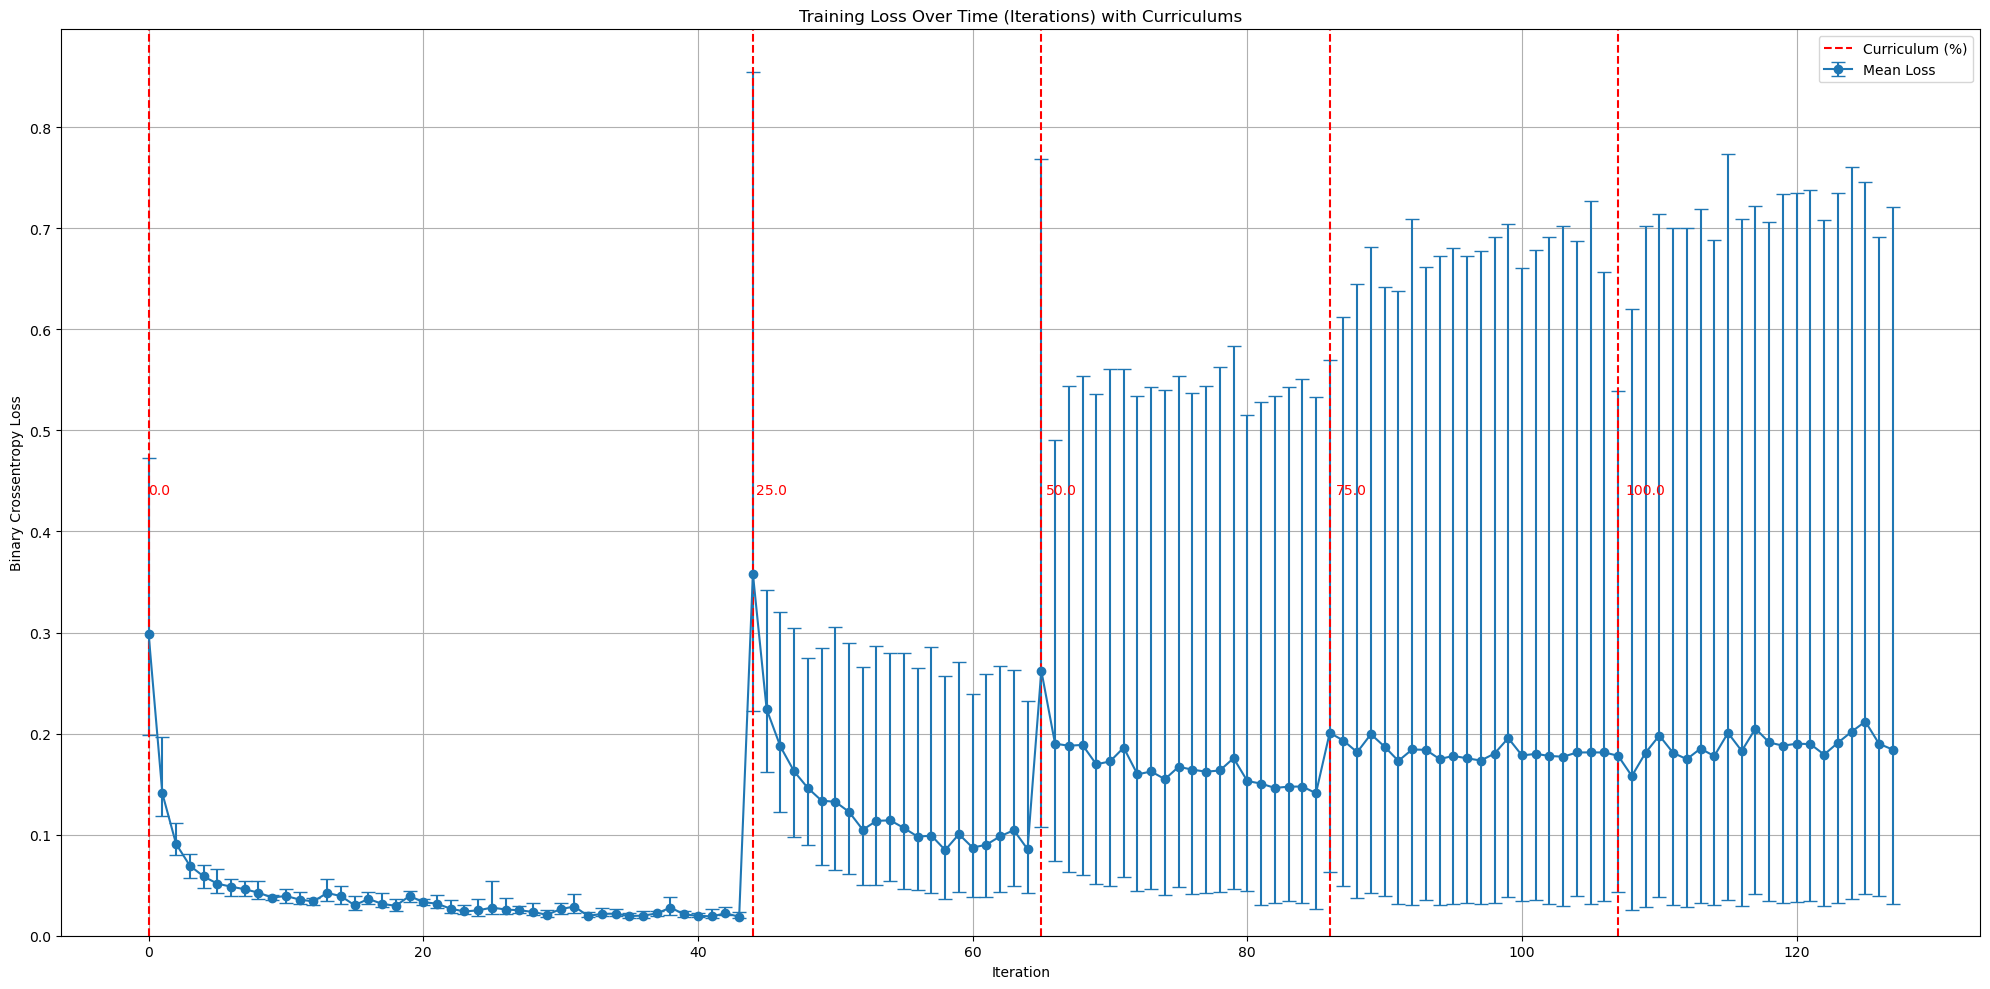

In [9]:
with open("training_data.json", "r") as f:
    recorded_data = json.load(f)

loss_points = []
curriculum_points = []
all_iterations = []

for curriculum, records in recorded_data.items():
    for iteration, data in records:
        min_loss, mean_loss, max_loss = data["loss"]
        loss_points.append((iteration, mean_loss, min_loss, max_loss))
        all_iterations.append(iteration)

    if records:
        curriculum_points.append((records[0][0], float(curriculum)))

iterations, mean_losses, min_losses, max_losses = zip(*loss_points)

plt.figure(figsize=(20, 10))

loss_error_bars = [[mean_loss - min_loss for mean_loss, min_loss in zip(mean_losses, min_losses)],
                   [max_loss - mean_loss for max_loss, mean_loss in zip(max_losses, mean_losses)]]

plt.errorbar(iterations, mean_losses, yerr=loss_error_bars, fmt="-o", label="Mean Loss", capsize=5)

placed = False
for time_step, curriculum in curriculum_points:
    if not placed:
        plt.axvline(x=time_step, color="red", linestyle="--", linewidth=1.5, ymin=0, ymax=999,
                    label="Curriculum (%)")
        placed = True
    else:
        plt.axvline(x=time_step, color="red", linestyle="--", linewidth=1.5, ymin=0, ymax=999)
    plt.text(time_step * 1.005, plt.ylim()[1] * 0.50, f"{float(curriculum * 100):.1f}",
             rotation=0,
             verticalalignment="top",
             color="red")

plt.title("Training Loss Over Time (Iterations) with Curriculums")
plt.xlabel("Iteration")
plt.ylabel("Binary Crossentropy Loss")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

## Loss vs. Sequence Length

In [10]:
model_demonstration = tf.keras.models.load_model(f"models/best_model_curriculum_level_{max_curriculums}.h5")

In [11]:
length = 32

In [12]:
X_demonstration = [
    [i * (i + 1) // 2 for i in range(1, length)],
    [2 * i + 1 for i in range(1, length)],
    [i * i for i in range(1, length)],
    [pow(2, i) for i in range(1, length)],
    [(i * i) - pow(i, 10) for i in range(1, length)],
    [5 - i // 3 for i in range(1, length)],
    [math.factorial(i) + (i * (i + 1)) // 2 for i in range(1, length)],
]

# ADD | SUB | MULT | FLOOR_DIV | FIB | POW | FACTORIAL | TRIANGULAR

y_demonstration = [
    [0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 1, 1],
]

In [13]:
lines = [[] for _ in range(len(X_demonstration))]
for i in range(1, length):
    for j, X in enumerate(X_demonstration):
        inputs = preprocessor.preprocess([X[:i]], use_static_embedding=False)
        predictions = model_demonstration.predict(inputs, verbose=0)
        val = tf.keras.losses.binary_crossentropy(y_demonstration[j], predictions).numpy()
        lines[j].append(val)

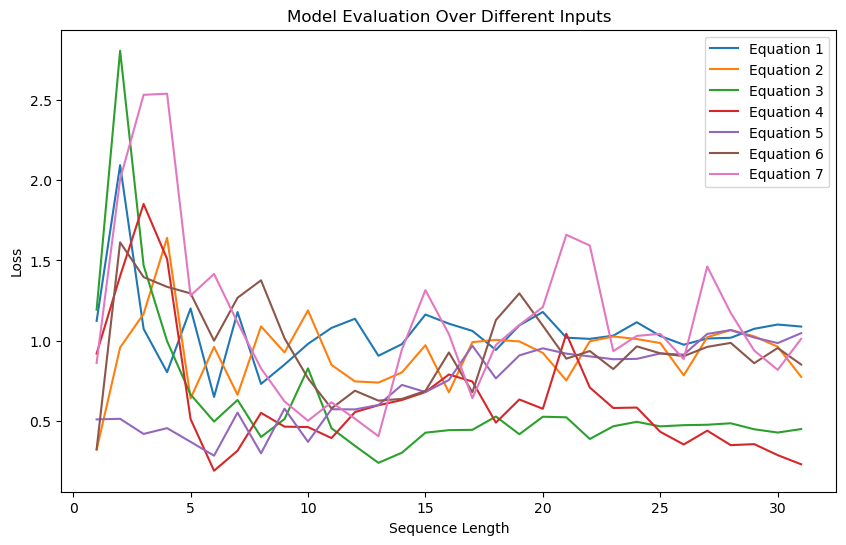

In [14]:
plt.figure(figsize=(10, 6))
for i, line in enumerate(lines):
    plt.plot(range(1, length), line, label=f"Equation {i + 1}")
plt.title("Model Evaluation Over Different Inputs")
plt.xlabel("Sequence Length")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Raw Observation

In [15]:
for X, y in zip(X_demonstration, y_demonstration):
    y_pred = model_demonstration.predict(preprocessor.preprocess([X[:18]], use_static_embedding=False), verbose=0)
    print("Input:", X[:18])
    print("Pred:", [round(x1) for x in y_pred for x1 in x])
    print("True:", y)
    print()

Input: [1, 3, 6, 10, 15, 21, 28, 36, 45, 55, 66, 78, 91, 105, 120, 136, 153, 171]
Pred: [0, 1, 1, 0, 0, 0, 0, 1]
True: [0, 0, 0, 0, 0, 0, 0, 1]

Input: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]
Pred: [1, 1, 0, 1, 0, 0, 0, 0]
True: [1, 0, 1, 0, 0, 0, 0, 0]

Input: [1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324]
Pred: [0, 1, 1, 0, 0, 0, 0, 0]
True: [0, 0, 1, 0, 0, 0, 0, 0]

Input: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
Pred: [0, 1, 0, 0, 0, 1, 0, 0]
True: [0, 0, 0, 0, 0, 1, 0, 0]

Input: [0, -1020, -59040, -1048560, -9765600, -60466140, -282475200, -1073741760, -3486784320, -9999999900, -25937424480, -61917364080, -137858491680, -289254654780, -576650390400, -1099511627520, -2015993900160, -3570467226300]
Pred: [0, 1, 0, 0, 0, 1, 0, 1]
True: [0, 1, 1, 0, 0, 1, 0, 0]

Input: [5, 5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 0, 0, -1]
Pred: [1, 1, 0, 1, 0, 0, 0, 1]
True: [0, 1, 

## Model performance at each curriculum on every curriculum

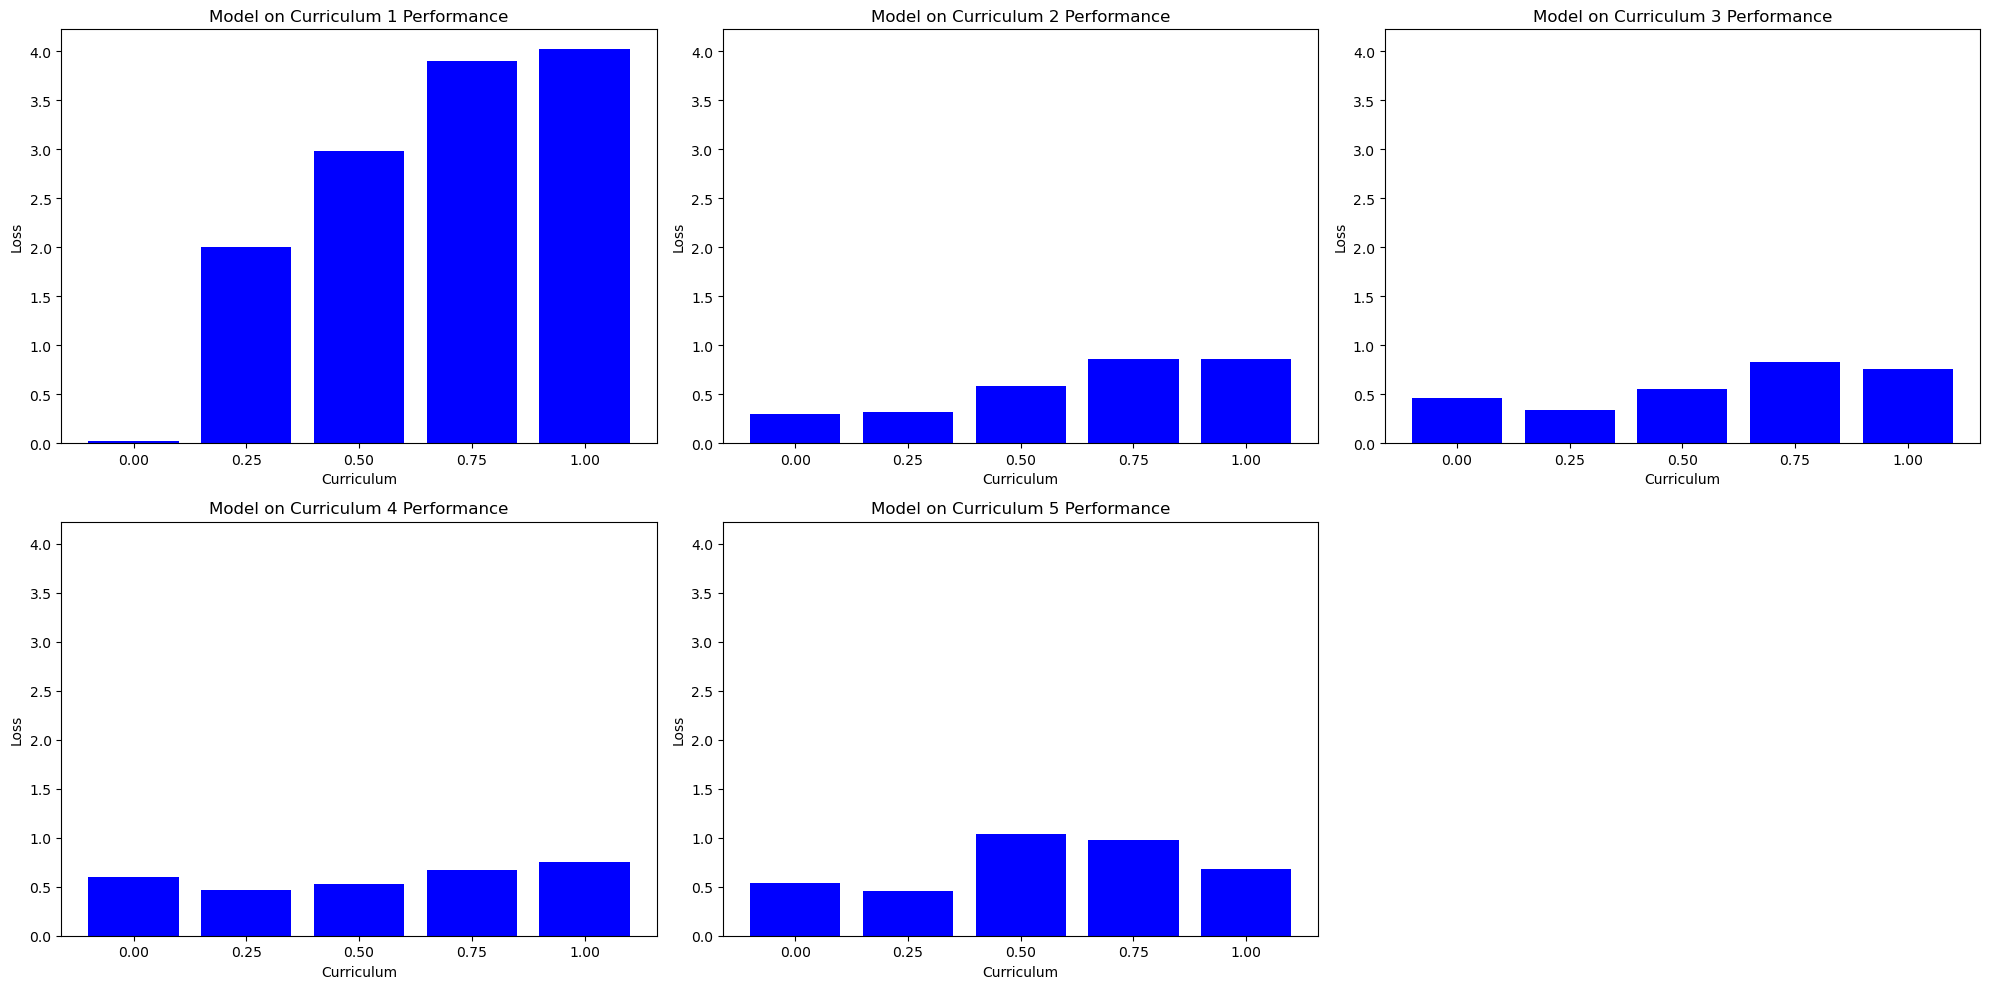

In [16]:
def plot_model_performances(models, datasets):
    results = []
    for model in models:
        model_results = []
        for X, y in datasets:
            evaluation = model.evaluate(X, y, verbose=0, batch_size=256)
            model_results.append(evaluation)
        results.append(model_results)
    results = np.array(results)

    largest_result = np.max(results)
    num_models = len(models)
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    num_datasets = len(datasets)

    for i, ax in enumerate(axes):
        if i < num_models:
            ax.bar(range(num_datasets), results[i, :], color="blue")
            ax.set_title(f"Model on Curriculum {i + 1} Performance")
            ax.set_xticks(range(num_datasets))
            ax.set_xticklabels([f"{j / (num_datasets - 1):.2f}" for j in range(num_datasets)])
            ax.set_xlabel("Curriculum")
            ax.set_ylabel("Loss")
            ax.set_ylim(0, largest_result * 1.05)
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


models = [tf.keras.models.load_model(f"models/best_model_curriculum_level_{i}.h5") for i in
          range(1, max_curriculums + 1)]
datasets = [build_dataset([200], [complexity], vocabulary, preprocessor) for complexity in curriculums]
plot_model_performances(models, datasets)

## Trained Model vs. Random Model

In [17]:
X, y = build_dataset([1000] * max_curriculums, curriculums, vocabulary, preprocessor)

In [18]:
predictions = model.predict(X, batch_size=256, verbose=0)

In [19]:
trained_accuracies = []
random_accuracies = []
for true_row, pred_row in zip(y, predictions):
    trained_accuracy = np.sum(np.round(pred_row) == true_row.numpy())
    trained_accuracies.append(trained_accuracy / len(true_row))

    random_accuracy = np.sum(np.array([random.randint(0, 1) for _ in range(len(true_row))]) == true_row.numpy())
    random_accuracies.append(random_accuracy / len(true_row))

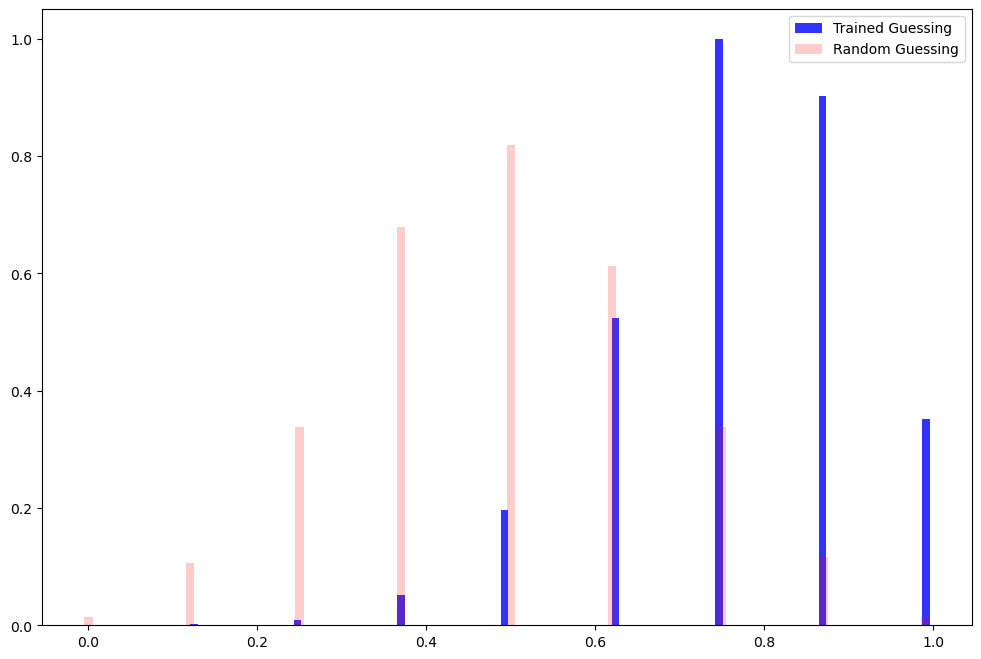

In [20]:
trained_counts, trained_bins = np.histogram(trained_accuracies, bins=100)
random_counts, random_bins = np.histogram(random_accuracies, bins=100)

largest_height = max(trained_counts.max(), random_counts.max())
trained_heights = trained_counts / largest_height
random_heights = random_counts / largest_height

trained_bin_widths = np.diff(trained_bins)
random_bin_widths = np.diff(random_bins)

plt.figure(figsize=(12, 8))
plt.bar(trained_bins[:-1], trained_heights, width=trained_bin_widths, label="Trained Guessing", color="blue", alpha=0.8)
plt.bar(random_bins[:-1], random_heights, width=random_bin_widths, label="Random Guessing", color="red", alpha=0.2)
plt.legend()
plt.show()